In [46]:
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount = True)
except:
    pass

In [47]:
import os
try:
    ROOT_PATH = "/content/drive/MyDrive/EE452_2024_Team5_Project/"  # Replace with your directory to A3 folder
    print(os.listdir(ROOT_PATH)) # Check the content of the path
    os.chdir(ROOT_PATH) # cd into directory
    print(os.listdir(".")) # Check the content of current folder
except:
    pass

In [48]:
from src.ngcf import NGCF
import pandas as pd
import torch
import networkx as nx
from sklearn.model_selection import train_test_split

import json
import os
from time import time
from datetime import datetime

from src.ngcf_utils.load_data import Data
from src.ngcf_utils.parser import parse_args
from src.ngcf_utils.helper_functions import early_stopping,\
                                   train,\
                                   split_matrix,\
                                   compute_ndcg_k,\
                                   eval_model,\
                                   probability_matrix
from src.ngcf import NGCF

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2 Positive Interaction Prediction (Neural Graph Collaborative Filtering)

In [49]:
ngcf_link_predictor_folder = "data/ngcf_interaction_predictor/"

In [50]:
!pip install --upgrade wandb

In [51]:
import wandb

try:
    from google.colab import userdata
    wandbkey = userdata.get('WANDB_KEY')
except:
    pass

try:
    wandb.finish()
except:
    pass

try:
    wandb.login(key=wandbkey)
except:
    wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kaede-johnson (hans-kvaerum). Use `wandb login --relogin` to force relogin


### 2a Define train functions

In [52]:
def prep_data(to_reads):
    # load in graph
    if to_reads == True:
        train_graph = nx.read_graphml("data/bipartite_sample_train_wtr.graphml")
        test_graph = nx.read_graphml("data/bipartite_sample_test_wtr.graphml")
    else:
        train_graph = nx.read_graphml("data/bipartite_sample_train.graphml")
        test_graph = nx.read_graphml("data/bipartite_sample_test.graphml")

    combined_graph = nx.compose(train_graph, test_graph)
    # create node name to index mapping
    ## based on codebase for NGCF, indices for both sets start at 0!
    user_nodes = {node for node, node_type in combined_graph.nodes(data=True) if node_type['node_type'] == 'user'}
    book_nodes = {book for book, node_type in combined_graph.nodes(data=True) if node_type['node_type'] == 'book'}
    book_to_idx_map = {node: i for i, node in enumerate(book_nodes)}
    user_to_idx_map = {node: i for i, node in enumerate(user_nodes)}
    with open(ngcf_link_predictor_folder + 'book_to_idx_map.json', 'w') as json_file:
        json.dump(book_to_idx_map, json_file, indent=4)
    with open(ngcf_link_predictor_folder + 'user_to_idx_map.json', 'w') as json_file:
        json.dump(user_to_idx_map, json_file, indent=4)
    user_count = len(user_to_idx_map.keys()) # used in wandb naming below
    book_count = len(book_to_idx_map.keys()) # used in wandb naming below

    # save train and test in format suited for NGCF codebase
    def save_graph_edges_to_txt(G, filename):
        with open(filename, 'w') as file:
            for node, data in G.nodes(data=True):
                if data['node_type'] == 'user':
                    user_node = node # just to make following commands clearer
                    neighbors = list(G.neighbors(user_node))
                    user_node_remapped = user_to_idx_map[user_node]
                    line = f"{user_node_remapped} " + " ".join(map(str, [book_to_idx_map[neighbor] for neighbor in neighbors]))
                    file.write(line + '\n')
    save_graph_edges_to_txt(train_graph, ngcf_link_predictor_folder + "ngcf_train.txt")
    save_graph_edges_to_txt(test_graph, ngcf_link_predictor_folder + "ngcf_test.txt")
    return user_count, book_count, user_to_idx_map, book_to_idx_map

In [9]:
def init_wandb(loss, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs):
    # create model name
    modelname =  "LP_" + \
        "_loss_" + str(loss) + \
        "_tr_" + str(to_reads) + \
        "_pcutoff_" + str(prob_cutoff) + \
        "_poswght_" + str(pos_weight) + \
        "_bs_" + str(batch_size) + \
        "_layers_" + str(layers) + \
        "_nemb_" + str(emb_dim) + \
        "_lr_"  + str(lr) + \
        "_reg_" + str(reg) + \
        "_messdr_" + str(mess_dropout) + \
        "_nodedr_" + str(node_dropout) + \
        "_ucount_" + str(user_count) + \
        "_bcount_" + str(book_count)

    # set wandb init
    wandb.init(

        # set the wandb project where this run will be logged
        project="nml_project",

        # name run
        name=modelname,

        # track hyperparameters and run metadata
        config={
        "architecture": "NGCF",
        "loss": str(loss),
        "tr": str(to_reads),
        "pcutoff": str(prob_cutoff),
        "batch_size": batch_size,
        "layers": layers,
        "emb_dim": emb_dim,
        "lr": lr,
        "reg": reg,
        "mess_dropout": mess_dropout,
        "node_dropout": node_dropout,
        "user_count": user_count,
        "book_count": book_count,
        "k": k,
        "epochs": n_epochs,
        }
    )

    return modelname

In [13]:
def train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, modelname):

    # generate the NGCF-adjacency matrix
    data_generator = Data(path=ngcf_link_predictor_folder, batch_size=batch_size)
    adj_mtx = data_generator.get_adj_mat()

    # create NGCF model
    model = NGCF(user_count,
                    book_count,
                    emb_dim,
                    layers,
                    reg,
                    node_dropout,
                    mess_dropout,
                    adj_mtx,
                    pos_weight,
                    prob_cutoff,
                    loss_name)
    if use_cuda:
        model = model.cuda()

    # current best metric
    cur_best_metric = 0

    # Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Set values for early stopping
    cur_best_loss, stopping_step, should_stop = 1e3, 0, False
    today = datetime.now()
    date = today.strftime("%d%m%Y_%H%M")
    results = {"Epoch": [],
                "Loss": [],
                "Precision": [],
                "Recall": [],
                "NDCG": [],
                "Training Time": []}

    for epoch in range(n_epochs):

        t1 = time()
        loss = train(model, data_generator, optimizer)
        training_time = time()-t1
        print("Epoch: {}, Training time: {:.2f}s, Loss: {:.4f}".
            format(epoch, training_time, loss))

        wandb.log({"training_loss": loss})

        # print test evaluation metrics every N epochs (provided by eval_N)
        if epoch % eval_N  == (eval_N - 1):
            with torch.no_grad():
                t2 = time()
                precision, recall, ndcg = eval_model(model.u_g_embeddings.detach().to(device),
                                            model.i_g_embeddings.detach().to(device),
                                            data_generator.R_train,
                                            data_generator.R_test,
                                            k,
                                            device)
            #print(
            #    "Evaluate current model:\n",
            #    "Epoch: {}, Validation time: {:.2f}s".format(epoch, time()-t2),"\n",
            #    "Loss: {:.4f}:".format(loss), "\n",
            #    "Recall@{}: {:.4f}".format(k, recall), "\n",
            #    "NDCG@{}: {:.4f}".format(k, ndcg)
            #    )

            cur_best_metric, stopping_step, should_stop = \
            early_stopping(recall, cur_best_metric, stopping_step, flag_step=5)

            # save results in dict
            results['Epoch'].append(epoch)
            results['Loss'].append(loss)
            results['Precision'].append(precision.item())
            results['Recall'].append(recall.item())
            results['NDCG'].append(ndcg.item())
            results['Training Time'].append(training_time)

            p_mat, test_recall, test_precision, test_f1_score = probability_matrix(model.u_g_embeddings.detach().to(device),
                                            model.i_g_embeddings.detach().to(device),
                                            data_generator.R_train,
                                            data_generator.R_test,
                                            device)

            wandb.log({f"test_recall": test_recall, f"test_precision": test_precision, f"test_f1_score": test_f1_score, f"rec_{k}": recall.item(), f"ndcg_{k}": ndcg.item()})

            # save model as .pt file
            if os.path.isdir(ngcf_link_predictor_folder + "/models"):
                torch.save(model.state_dict(), ngcf_link_predictor_folder + "/models/" + str(date) + "_" + modelname + "_epoch_" + str(epoch) + ".pt")
            else:
                os.mkdir(ngcf_link_predictor_folder + "/models")
                torch.save(model.state_dict(), ngcf_link_predictor_folder + "/models/" + str(date) + "_" + modelname + "_epoch_" + str(epoch) + ".pt")

        else:
            # save results in dict
            results['Epoch'].append(epoch)
            results['Loss'].append(loss)
            results['Precision'].append(None)
            results['Recall'].append(None)
            results['NDCG'].append(None)
            results['Training Time'].append(training_time)

        if should_stop == True: break

    wandb.finish()

    # save
    if save_results:
        date = today.strftime("%d%m%Y_%H%M")

        # save model as .pt file
        if os.path.isdir(ngcf_link_predictor_folder + "/models"):
            torch.save(model.state_dict(), ngcf_link_predictor_folder + "/models" + str(date) + "_" + modelname + ".pt")
        else:
            os.mkdir(ngcf_link_predictor_folder + "/models")
            torch.save(model.state_dict(), ngcf_link_predictor_folder + "/models" + str(date) + "_" + modelname + ".pt")

        # save results as pandas dataframe
        results_df = pd.DataFrame(results)
        results_df.set_index('Epoch', inplace=True)
        if os.path.isdir(ngcf_link_predictor_folder + "/results"):
            results_df.to_csv(ngcf_link_predictor_folder + "/results" + str(date) + "_" + modelname + ".csv")
        else:
            os.mkdir(ngcf_link_predictor_folder + "/results")
            results_df.to_csv(ngcf_link_predictor_folder + "/results" + str(date) + "_" + modelname + ".csv")
        # plot loss
        results_df['Loss'].plot(figsize=(12,8), title='Loss')

### 2b) Train! Chosen model from 2c on full subset

In [53]:
# custom
loss_name = 'bce' # 'bpr' or 'bce'
to_reads = True # True or False
prob_cutoff = .90 # threshold above which a positive interaction is predicted to occur
pos_weight = 1 # weight for positive class in BCE loss (helps for imbalanced data). 1 = no reweighting

# standard
batch_size = 16
layers = [16, 32]
emb_dim = 52
lr = 0.015
reg = 0.005
mess_dropout = 0.01
node_dropout = 0.01
k = 20
n_epochs = 40
save_results = True
eval_N = 1 # how often to print eval results

ndcg_20,▁
rec_20,▁
test_f1_score,▁
test_precision,▁
test_recall,▁
training_loss,▁▆██
ndcg_20,0.34632
rec_20,0.07567
test_f1_score,0.09139
test_precision,0.05061
test_recall,0.47006


n_users=3000, n_items=1500
n_interactions=218592
n_train=151596, n_test=66996, sparsity=0.04858
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 2.0182368755340576 sec
Creating adjacency-matrix...
Complete. Adjacency-matrix created in (4500, 4500) 0.6544749736785889 sec.
Transforming adjacency-matrix to NGCF-adjacency matrix...
Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in 0.37917113304138184 sec.
Initializing weights...
Weights initialized.


100%|██████████| 9475/9475 [04:46<00:00, 33.12it/s]


Epoch: 0, Training time: 286.06s, Loss: 9393.2882
Counter({1.0: 66996})
635607 28473 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:45<00:00, 33.23it/s]


Epoch: 1, Training time: 285.19s, Loss: 10282.8805
Counter({1.0: 66996})
669890 31742 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:48<00:00, 32.87it/s]


Epoch: 2, Training time: 288.29s, Loss: 10552.2395
Counter({1.0: 66996})
650100 31615 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:45<00:00, 33.13it/s]


Epoch: 3, Training time: 286.00s, Loss: 10523.0636
Counter({1.0: 66996})
644948 32196 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:44<00:00, 33.25it/s]


Epoch: 4, Training time: 284.95s, Loss: 10451.3881
Counter({1.0: 66996})
637039 32526 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:44<00:00, 33.32it/s]


Epoch: 5, Training time: 284.38s, Loss: 10297.8228
Counter({1.0: 66996})
642827 32559 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:45<00:00, 33.20it/s]


Epoch: 6, Training time: 285.40s, Loss: 10246.1219
Counter({1.0: 66996})
635274 32714 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:49<00:00, 32.74it/s]


Epoch: 7, Training time: 289.37s, Loss: 10264.7158
Counter({1.0: 66996})
605998 32113 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:43<00:00, 33.37it/s]


Epoch: 8, Training time: 283.93s, Loss: 10163.5042
Counter({1.0: 66996})
618176 32658 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:45<00:00, 33.20it/s]


Epoch: 9, Training time: 285.38s, Loss: 10155.6708
Counter({1.0: 66996})
602788 31871 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:44<00:00, 33.27it/s]


Epoch: 10, Training time: 284.78s, Loss: 10092.7953
Counter({1.0: 66996})
602789 33125 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:44<00:00, 33.34it/s]


Epoch: 11, Training time: 284.18s, Loss: 10076.8155
Counter({1.0: 66996})
596240 32018 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:44<00:00, 33.29it/s]


Epoch: 12, Training time: 284.63s, Loss: 10027.9403
Counter({1.0: 66996})
597199 32564 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:42<00:00, 33.50it/s]


Epoch: 13, Training time: 282.86s, Loss: 9968.6194
Counter({1.0: 66996})
577859 32432 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:43<00:00, 33.47it/s]


Epoch: 14, Training time: 283.12s, Loss: 9997.6854
Counter({1.0: 66996})
587895 32206 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:44<00:00, 33.36it/s]


Epoch: 15, Training time: 284.02s, Loss: 9949.1143
Counter({1.0: 66996})
597320 32851 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:43<00:00, 33.43it/s]


Epoch: 16, Training time: 283.41s, Loss: 9920.4481
Counter({1.0: 66996})
593497 33287 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:44<00:00, 33.32it/s]


Epoch: 17, Training time: 284.39s, Loss: 9960.5576
Counter({1.0: 66996})
596094 33284 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:45<00:00, 33.23it/s]


Epoch: 18, Training time: 285.15s, Loss: 9916.0219
Counter({1.0: 66996})
579873 32646 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:56<00:00, 31.92it/s]


Epoch: 19, Training time: 296.87s, Loss: 9883.0457
Counter({1.0: 66996})
568780 32156 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:54<00:00, 32.20it/s]


Epoch: 20, Training time: 294.22s, Loss: 9816.4221
Counter({1.0: 66996})
591380 32778 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


100%|██████████| 9475/9475 [04:56<00:00, 31.99it/s]


Epoch: 21, Training time: 296.16s, Loss: 9868.9804
Early stopping at step: 5 log:0.0803622230887413
Counter({1.0: 66996})
591533 32482 66996 (3000, 1500) torch.Size([3000, 100]) torch.Size([1500, 100]) (3000, 1500)


ndcg_20,▁▂▃▅▄▄▆▆▅▆▆▆▆█▆▆▇▇▇█▇▆
rec_20,▁▂▃▅▄▄▅▅▅▆▆▆▆▇▆▆█▇▇▇▇▆
test_f1_score,▁▃▃▄▅▅▅▆▆▆▇▆▇█▇▇████▇▇
test_precision,▁▃▃▄▅▄▅▆▆▆▇▆▇█▇▇████▇▇
test_recall,▁▆▆▆▇▇▇▆▇▆█▆▇▇▆▇██▇▆▇▇
training_loss,▁▆██▇▆▆▆▆▆▅▅▅▄▅▄▄▄▄▄▄▄
ndcg_20,0.36112
rec_20,0.08036
test_f1_score,0.09865
test_precision,0.05491
test_recall,0.48483


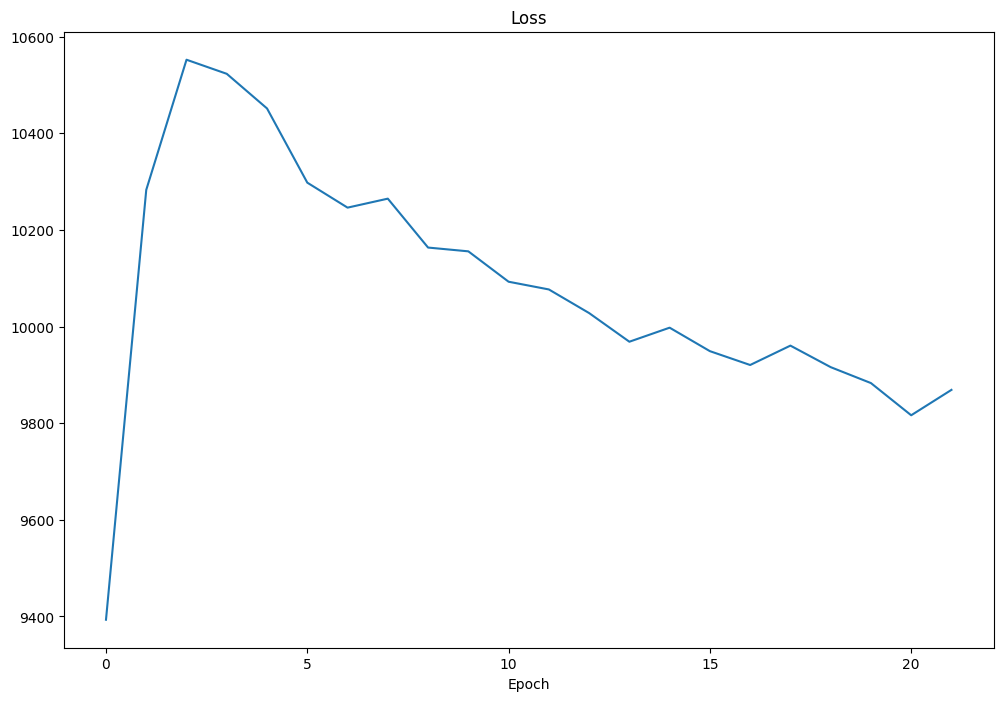

In [17]:
# create adjacency matrix from graph
user_count, book_count, user_to_idx_map, book_to_idx_map = prep_data(to_reads)

# start wandb run
model_name = init_wandb(loss_name, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs)

# train the model and output results
train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, model_name)

In [18]:
# custom
loss_name = 'bce' # 'bpr' or 'bce'
to_reads = True # True or False
prob_cutoff = .90 # threshold above which a positive interaction is predicted to occur
pos_weight = 1 # weight for positive class in BCE loss (helps for imbalanced data). 1 = no reweighting

# standard
batch_size = 16
layers = [64, 64, 32, 32]
emb_dim = 64
lr = 0.02
reg = 0.005
mess_dropout = 0.01
node_dropout = 0.01
k = 20
n_epochs = 40
save_results = True
eval_N = 1 # how often to print eval results

In [ ]:
# create adjacency matrix from graph
user_count, book_count, user_to_idx_map, book_to_idx_map = prep_data(to_reads)

# start wandb run
model_name = init_wandb(loss_name, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs)

# train the model and output results
train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, model_name)

n_users=3000, n_items=1500
n_interactions=218592
n_train=151596, n_test=66996, sparsity=0.04858
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 2.142491102218628 sec
Creating adjacency-matrix...
Complete. Adjacency-matrix created in (4500, 4500) 0.6999733448028564 sec.
Transforming adjacency-matrix to NGCF-adjacency matrix...
Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in 0.21280646324157715 sec.
Initializing weights...
Weights initialized.


100%|██████████| 9475/9475 [08:45<00:00, 18.04it/s]


Epoch: 0, Training time: 525.16s, Loss: 16325.1475
Counter({1.0: 66996})
985239 35098 66996 (3000, 1500) torch.Size([3000, 256]) torch.Size([1500, 256]) (3000, 1500)


100%|██████████| 9475/9475 [08:42<00:00, 18.13it/s]


Epoch: 1, Training time: 522.73s, Loss: 19426.4085
Counter({1.0: 66996})
942383 36151 66996 (3000, 1500) torch.Size([3000, 256]) torch.Size([1500, 256]) (3000, 1500)


100%|██████████| 9475/9475 [08:38<00:00, 18.27it/s]


Epoch: 2, Training time: 518.53s, Loss: 20325.6546
Counter({1.0: 66996})
913867 36870 66996 (3000, 1500) torch.Size([3000, 256]) torch.Size([1500, 256]) (3000, 1500)


100%|██████████| 9475/9475 [08:32<00:00, 18.48it/s]


Epoch: 3, Training time: 512.86s, Loss: 20712.8864
Counter({1.0: 66996})
899881 36867 66996 (3000, 1500) torch.Size([3000, 256]) torch.Size([1500, 256]) (3000, 1500)


100%|██████████| 9475/9475 [08:41<00:00, 18.18it/s]


Epoch: 4, Training time: 521.27s, Loss: 20790.7425
Counter({1.0: 66996})
896700 37454 66996 (3000, 1500) torch.Size([3000, 256]) torch.Size([1500, 256]) (3000, 1500)


100%|██████████| 9475/9475 [08:37<00:00, 18.30it/s]


Epoch: 5, Training time: 517.73s, Loss: 20767.2193
Counter({1.0: 66996})
873611 37219 66996 (3000, 1500) torch.Size([3000, 256]) torch.Size([1500, 256]) (3000, 1500)


100%|██████████| 9475/9475 [08:36<00:00, 18.35it/s]


Epoch: 6, Training time: 516.26s, Loss: 20698.9579
Counter({1.0: 66996})
870452 37225 66996 (3000, 1500) torch.Size([3000, 256]) torch.Size([1500, 256]) (3000, 1500)


100%|██████████| 9475/9475 [08:35<00:00, 18.40it/s]


Epoch: 7, Training time: 515.08s, Loss: 20580.5893
Counter({1.0: 66996})
863257 37597 66996 (3000, 1500) torch.Size([3000, 256]) torch.Size([1500, 256]) (3000, 1500)


100%|██████████| 9475/9475 [08:36<00:00, 18.36it/s]


Epoch: 8, Training time: 516.14s, Loss: 20642.4032
Counter({1.0: 66996})
831235 36809 66996 (3000, 1500) torch.Size([3000, 256]) torch.Size([1500, 256]) (3000, 1500)


 90%|█████████ | 8546/9475 [07:44<00:48, 19.01it/s]

### 2c) Train! Older trains that were done on a smaller subset (500 books, 1000 users) for model development

#### 2ci) BCE loss, to_reads

In [ ]:
# custom
loss_name = 'bce' # 'bpr' or 'bce'
to_reads = True # True or False
prob_cutoff = .90 # threshold above which a positive interaction is predicted to occur
pos_weight = 1 # weight for positive class in BCE loss (helps for imbalanced data). 1 = no reweighting

# standard
batch_size = 16
layers = [16, 32]
emb_dim = 52
lr = 0.015
reg = 0.005
mess_dropout = 0.01
node_dropout = 0.01
k = 20
n_epochs = 40
save_results = True
eval_N = 4 # how often to print eval results

In [ ]:
# create adjacency matrix from graph
user_count, book_count, user_to_idx_map, book_to_idx_map = prep_data(to_reads)

wandb: Currently logged in as: kaede-johnson (hans-kvaerum). Use `wandb login --relogin` to force relogin


n_users=1000, n_items=500
n_interactions=33787
n_train=23188, n_test=10599, sparsity=0.06757
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 0.38110899925231934 sec
Creating adjacency-matrix...
Complete. Adjacency-matrix created in (1500, 1500) 0.09061741828918457 sec.
Transforming adjacency-matrix to NGCF-adjacency matrix...


/content/drive/MyDrive/EE452_2024_Team5_Project/src/ngcf_utils/load_data.py:131: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -.5).flatten()


Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in 0.3132646083831787 sec.
Initializing weights...
Weights initialized.


100%|██████████| 1450/1450 [00:20<00:00, 70.57it/s]


Epoch: 0, Training time: 20.55s, Loss: 1015.2081


100%|██████████| 1450/1450 [00:19<00:00, 74.41it/s]


Epoch: 1, Training time: 19.50s, Loss: 866.0456


100%|██████████| 1450/1450 [00:18<00:00, 78.03it/s]


Epoch: 2, Training time: 18.59s, Loss: 826.3065


100%|██████████| 1450/1450 [00:17<00:00, 81.67it/s]


Epoch: 3, Training time: 17.76s, Loss: 811.2170
Counter({1.0: 10599})
31064 3185 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:18<00:00, 78.53it/s]


Epoch: 4, Training time: 18.49s, Loss: 813.8959


100%|██████████| 1450/1450 [00:17<00:00, 82.88it/s]


Epoch: 5, Training time: 17.50s, Loss: 803.3711


100%|██████████| 1450/1450 [00:17<00:00, 83.14it/s]


Epoch: 6, Training time: 17.45s, Loss: 798.7350


100%|██████████| 1450/1450 [00:18<00:00, 79.86it/s]


Epoch: 7, Training time: 18.17s, Loss: 802.7019
Counter({1.0: 10599})
27864 3067 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:19<00:00, 76.24it/s]


Epoch: 8, Training time: 19.03s, Loss: 801.2350


100%|██████████| 1450/1450 [00:17<00:00, 83.03it/s]


Epoch: 9, Training time: 17.47s, Loss: 814.4384


100%|██████████| 1450/1450 [00:18<00:00, 80.42it/s]


Epoch: 10, Training time: 18.04s, Loss: 801.3595


100%|██████████| 1450/1450 [00:18<00:00, 79.12it/s]


Epoch: 11, Training time: 18.34s, Loss: 795.8024
Counter({1.0: 10599})
29335 3287 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 81.91it/s]


Epoch: 12, Training time: 17.71s, Loss: 801.9614


100%|██████████| 1450/1450 [00:17<00:00, 82.80it/s]


Epoch: 13, Training time: 17.52s, Loss: 812.8539


100%|██████████| 1450/1450 [00:18<00:00, 78.13it/s]


Epoch: 14, Training time: 18.57s, Loss: 799.1587


100%|██████████| 1450/1450 [00:17<00:00, 82.52it/s]


Epoch: 15, Training time: 17.58s, Loss: 778.1379
Counter({1.0: 10599})
28367 3131 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:18<00:00, 78.06it/s]


Epoch: 16, Training time: 18.58s, Loss: 787.2888


100%|██████████| 1450/1450 [00:18<00:00, 77.82it/s]


Epoch: 17, Training time: 18.64s, Loss: 791.5018


100%|██████████| 1450/1450 [00:17<00:00, 82.32it/s]


Epoch: 18, Training time: 17.62s, Loss: 791.2983


100%|██████████| 1450/1450 [00:17<00:00, 82.01it/s]


Epoch: 19, Training time: 17.69s, Loss: 774.7850
Counter({1.0: 10599})
26578 3269 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:18<00:00, 79.19it/s]


Epoch: 20, Training time: 18.32s, Loss: 776.2425


100%|██████████| 1450/1450 [00:18<00:00, 79.03it/s]


Epoch: 21, Training time: 18.36s, Loss: 776.0953


100%|██████████| 1450/1450 [00:17<00:00, 82.66it/s]


Epoch: 22, Training time: 17.55s, Loss: 767.0201


100%|██████████| 1450/1450 [00:19<00:00, 75.39it/s]


Epoch: 23, Training time: 19.24s, Loss: 779.7708
Counter({1.0: 10599})
25652 3145 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:18<00:00, 77.62it/s]


Epoch: 24, Training time: 18.69s, Loss: 767.7224


100%|██████████| 1450/1450 [00:17<00:00, 81.67it/s]


Epoch: 25, Training time: 17.76s, Loss: 771.6515


100%|██████████| 1450/1450 [00:17<00:00, 81.99it/s]


Epoch: 26, Training time: 17.69s, Loss: 769.1948


100%|██████████| 1450/1450 [00:18<00:00, 78.18it/s]


Epoch: 27, Training time: 18.56s, Loss: 771.3233
Counter({1.0: 10599})
25636 3248 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 82.05it/s]


Epoch: 28, Training time: 17.69s, Loss: 749.3504


100%|██████████| 1450/1450 [00:17<00:00, 81.13it/s]


Epoch: 29, Training time: 17.88s, Loss: 744.4822


100%|██████████| 1450/1450 [00:19<00:00, 73.93it/s]


Epoch: 30, Training time: 19.62s, Loss: 754.0511


100%|██████████| 1450/1450 [00:17<00:00, 82.66it/s]


Epoch: 31, Training time: 17.55s, Loss: 751.0488
Counter({1.0: 10599})
24852 3149 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 82.56it/s]


Epoch: 32, Training time: 17.57s, Loss: 762.8502


100%|██████████| 1450/1450 [00:17<00:00, 81.33it/s]


Epoch: 33, Training time: 17.84s, Loss: 763.2628


100%|██████████| 1450/1450 [00:18<00:00, 79.95it/s]


Epoch: 34, Training time: 18.15s, Loss: 737.7470


100%|██████████| 1450/1450 [00:17<00:00, 83.26it/s]


Epoch: 35, Training time: 17.42s, Loss: 749.8038
Counter({1.0: 10599})
23867 3070 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 82.22it/s]


Epoch: 36, Training time: 17.64s, Loss: 754.4288


100%|██████████| 1450/1450 [00:18<00:00, 78.62it/s]


Epoch: 37, Training time: 18.45s, Loss: 762.7373


100%|██████████| 1450/1450 [00:18<00:00, 77.84it/s]


Epoch: 38, Training time: 18.64s, Loss: 749.5021


100%|██████████| 1450/1450 [00:17<00:00, 83.30it/s]


Epoch: 39, Training time: 17.42s, Loss: 746.8437
Counter({1.0: 10599})
23710 3032 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


ndcg_20,▁▁▃▂▅▅█▆▆▇
rec_20,▁▁▃▂▇▆█▇▆▅
test_f1_score,▁▃▄▃▇▆███▇
test_precision,▁▃▄▃▆▆▇▇██
test_recall,▅▂█▄█▄▇▄▂▁
training_loss,█▄▃▃▃▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▁▁▂▁▁
ndcg_20,0.48166
rec_20,0.23887
test_f1_score,0.17675
test_precision,0.12788
test_recall,0.28606


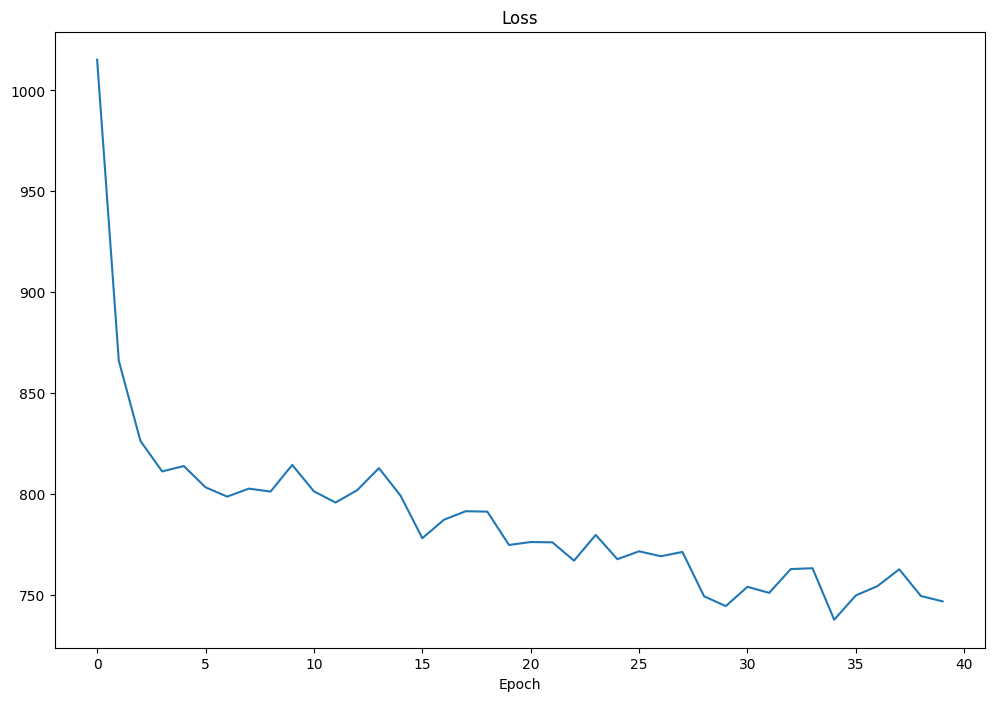

In [ ]:
# start wandb run
model_name = init_wandb(loss_name, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs)

# train the model and output results
train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, model_name)

#### 2cii) BPR loss, to_reads

n_users=1000, n_items=500
n_interactions=33787
n_train=23188, n_test=10599, sparsity=0.06757
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 0.5857284069061279 sec
Creating adjacency-matrix...
Complete. Adjacency-matrix created in (1500, 1500) 0.14017510414123535 sec.
Transforming adjacency-matrix to NGCF-adjacency matrix...


/content/drive/MyDrive/EE452_2024_Team5_Project/src/ngcf_utils/load_data.py:131: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -.5).flatten()


Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in 0.06469273567199707 sec.
Initializing weights...
Weights initialized.


100%|██████████| 1450/1450 [00:17<00:00, 82.25it/s]


Epoch: 0, Training time: 17.64s, Loss: 765.8626


100%|██████████| 1450/1450 [00:17<00:00, 83.23it/s]


Epoch: 1, Training time: 17.44s, Loss: 745.1461


100%|██████████| 1450/1450 [00:17<00:00, 83.12it/s]


Epoch: 2, Training time: 17.45s, Loss: 769.5161


100%|██████████| 1450/1450 [00:18<00:00, 79.39it/s]


Epoch: 3, Training time: 18.28s, Loss: 765.6932
Counter({1.0: 10599})
131386 7285 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:18<00:00, 77.19it/s]


Epoch: 4, Training time: 18.80s, Loss: 788.5918


100%|██████████| 1450/1450 [00:17<00:00, 83.17it/s]


Epoch: 5, Training time: 17.44s, Loss: 788.7698


100%|██████████| 1450/1450 [00:18<00:00, 78.69it/s]


Epoch: 6, Training time: 18.44s, Loss: 766.0799


100%|██████████| 1450/1450 [00:17<00:00, 83.71it/s]


Epoch: 7, Training time: 17.33s, Loss: 802.4394
Counter({1.0: 10599})
134400 7465 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 84.23it/s]


Epoch: 8, Training time: 17.22s, Loss: 797.5229


100%|██████████| 1450/1450 [00:17<00:00, 82.90it/s]


Epoch: 9, Training time: 17.50s, Loss: 798.4627


100%|██████████| 1450/1450 [00:18<00:00, 79.85it/s]


Epoch: 10, Training time: 18.17s, Loss: 809.7054


100%|██████████| 1450/1450 [00:18<00:00, 76.85it/s]


Epoch: 11, Training time: 18.88s, Loss: 812.9138
Counter({1.0: 10599})
134442 7375 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 84.18it/s]


Epoch: 12, Training time: 17.24s, Loss: 806.2782


100%|██████████| 1450/1450 [00:17<00:00, 82.68it/s]


Epoch: 13, Training time: 17.55s, Loss: 802.1696


100%|██████████| 1450/1450 [00:18<00:00, 79.89it/s]


Epoch: 14, Training time: 18.16s, Loss: 776.0330


100%|██████████| 1450/1450 [00:17<00:00, 83.19it/s]


Epoch: 15, Training time: 17.44s, Loss: 809.8856
Counter({1.0: 10599})
130791 7366 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 82.28it/s]


Epoch: 16, Training time: 17.64s, Loss: 772.6483


100%|██████████| 1450/1450 [00:18<00:00, 79.74it/s]


Epoch: 17, Training time: 18.19s, Loss: 792.4476


100%|██████████| 1450/1450 [00:18<00:00, 79.95it/s]


Epoch: 18, Training time: 18.15s, Loss: 815.3569


100%|██████████| 1450/1450 [00:18<00:00, 77.87it/s]


Epoch: 19, Training time: 18.64s, Loss: 787.3895
Counter({1.0: 10599})
129049 7304 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 82.28it/s]


Epoch: 20, Training time: 17.63s, Loss: 809.8976


100%|██████████| 1450/1450 [00:18<00:00, 79.43it/s]


Epoch: 21, Training time: 18.26s, Loss: 783.1214


100%|██████████| 1450/1450 [00:17<00:00, 83.09it/s]


Epoch: 22, Training time: 17.46s, Loss: 792.6291


100%|██████████| 1450/1450 [00:17<00:00, 83.53it/s]


Epoch: 23, Training time: 17.37s, Loss: 773.4163
Counter({1.0: 10599})
130766 7273 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:18<00:00, 79.80it/s]


Epoch: 24, Training time: 18.18s, Loss: 806.8856


100%|██████████| 1450/1450 [00:17<00:00, 82.57it/s]


Epoch: 25, Training time: 17.57s, Loss: 788.8416


100%|██████████| 1450/1450 [00:18<00:00, 77.57it/s]


Epoch: 26, Training time: 18.70s, Loss: 783.5219


100%|██████████| 1450/1450 [00:17<00:00, 83.31it/s]


Epoch: 27, Training time: 17.41s, Loss: 778.9768
Counter({1.0: 10599})
128736 7139 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:18<00:00, 78.44it/s]


Epoch: 28, Training time: 18.49s, Loss: 797.6464


100%|██████████| 1450/1450 [00:17<00:00, 83.58it/s]


Epoch: 29, Training time: 17.36s, Loss: 801.0894


100%|██████████| 1450/1450 [00:17<00:00, 83.56it/s]


Epoch: 30, Training time: 17.36s, Loss: 823.9558


100%|██████████| 1450/1450 [00:17<00:00, 80.95it/s]


Epoch: 31, Training time: 17.92s, Loss: 765.1386
Counter({1.0: 10599})
127255 7237 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 82.10it/s]


Epoch: 32, Training time: 17.67s, Loss: 797.4362


100%|██████████| 1450/1450 [00:18<00:00, 78.48it/s]


Epoch: 33, Training time: 18.49s, Loss: 793.0027


100%|██████████| 1450/1450 [00:17<00:00, 81.88it/s]


Epoch: 34, Training time: 17.72s, Loss: 794.2541


100%|██████████| 1450/1450 [00:18<00:00, 79.95it/s]


Epoch: 35, Training time: 18.16s, Loss: 790.0586
Counter({1.0: 10599})
126733 7288 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 83.58it/s]


Epoch: 36, Training time: 17.36s, Loss: 805.3616


100%|██████████| 1450/1450 [00:17<00:00, 83.44it/s]


Epoch: 37, Training time: 17.39s, Loss: 775.5205


100%|██████████| 1450/1450 [00:18<00:00, 79.09it/s]


Epoch: 38, Training time: 18.34s, Loss: 775.8421


100%|██████████| 1450/1450 [00:18<00:00, 78.68it/s]


Epoch: 39, Training time: 18.44s, Loss: 783.2289
Counter({1.0: 10599})
124556 7188 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


ndcg_20,▁▆▆▄▆▅█▇█▆
rec_20,▁▅▅▆▅▅▆▆█▇
test_f1_score,▂▃▁▅▅▃▂▆██
test_precision,▂▃▁▅▅▃▂▆██
test_recall,▄█▆▆▅▄▁▃▄▂
training_loss,▃▁▃▃▅▅▃▆▆▆▇▇▆▆▄▇▃▅▇▅▇▄▅▄▆▅▄▄▆▆█▃▆▅▅▅▆▄▄▄
ndcg_20,0.46405
rec_20,0.23548
test_f1_score,0.10637
test_precision,0.05771
test_recall,0.67818


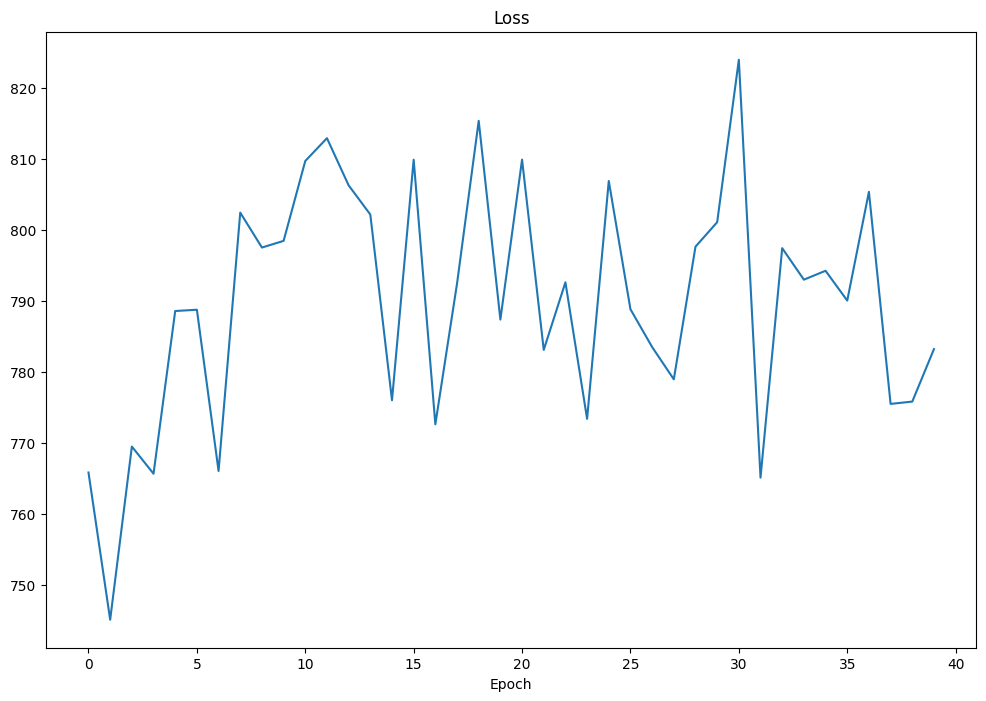

In [ ]:
loss_name = 'bpr'

# start wandb run
model_name = init_wandb(loss_name, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs)

# train the model and output results
train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, model_name)

#### 2ciii) BCE loss, no to_reads

n_users=1000, n_items=500
n_interactions=30979
n_train=21220, n_test=9759, sparsity=0.06196
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 0.522310733795166 sec
Creating adjacency-matrix...
Complete. Adjacency-matrix created in (1500, 1500) 0.12672638893127441 sec.
Transforming adjacency-matrix to NGCF-adjacency matrix...
Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in 0.05885457992553711 sec.


/content/drive/MyDrive/EE452_2024_Team5_Project/src/ngcf_utils/load_data.py:131: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -.5).flatten()


Initializing weights...
Weights initialized.


100%|██████████| 1327/1327 [00:16<00:00, 78.86it/s]


Epoch: 0, Training time: 16.84s, Loss: 913.8515


100%|██████████| 1327/1327 [00:16<00:00, 82.92it/s]


Epoch: 1, Training time: 16.01s, Loss: 777.8154


100%|██████████| 1327/1327 [00:16<00:00, 82.75it/s]


Epoch: 2, Training time: 16.05s, Loss: 748.2602


100%|██████████| 1327/1327 [00:16<00:00, 82.67it/s]


Epoch: 3, Training time: 16.06s, Loss: 727.4134
Counter({1.0: 9759})
26359 2651 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:18<00:00, 73.36it/s]


Epoch: 4, Training time: 18.10s, Loss: 706.5835


100%|██████████| 1327/1327 [00:16<00:00, 79.86it/s]


Epoch: 5, Training time: 16.63s, Loss: 694.6266


100%|██████████| 1327/1327 [00:15<00:00, 83.05it/s]


Epoch: 6, Training time: 15.99s, Loss: 701.2932


100%|██████████| 1327/1327 [00:17<00:00, 75.01it/s]


Epoch: 7, Training time: 17.70s, Loss: 701.9724
Counter({1.0: 9759})
25530 2734 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:16<00:00, 82.89it/s]


Epoch: 8, Training time: 16.02s, Loss: 701.4301


100%|██████████| 1327/1327 [00:16<00:00, 82.44it/s]


Epoch: 9, Training time: 16.10s, Loss: 682.9320


100%|██████████| 1327/1327 [00:16<00:00, 81.09it/s]


Epoch: 10, Training time: 16.38s, Loss: 686.5657


100%|██████████| 1327/1327 [00:16<00:00, 79.76it/s]


Epoch: 11, Training time: 16.65s, Loss: 696.9556
Counter({1.0: 9759})
25147 2788 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:15<00:00, 82.96it/s]


Epoch: 12, Training time: 16.00s, Loss: 691.7469


100%|██████████| 1327/1327 [00:15<00:00, 83.44it/s]


Epoch: 13, Training time: 15.91s, Loss: 686.2089


100%|██████████| 1327/1327 [00:15<00:00, 83.38it/s]


Epoch: 14, Training time: 15.92s, Loss: 702.5632


100%|██████████| 1327/1327 [00:17<00:00, 76.53it/s]


Epoch: 15, Training time: 17.35s, Loss: 689.0126
Counter({1.0: 9759})
26875 2890 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:17<00:00, 77.69it/s]


Epoch: 16, Training time: 17.10s, Loss: 702.2839


100%|██████████| 1327/1327 [00:16<00:00, 82.78it/s]


Epoch: 17, Training time: 16.04s, Loss: 688.1131


100%|██████████| 1327/1327 [00:16<00:00, 82.87it/s]


Epoch: 18, Training time: 16.02s, Loss: 694.4736


100%|██████████| 1327/1327 [00:15<00:00, 83.30it/s]


Epoch: 19, Training time: 15.94s, Loss: 676.7221
Counter({1.0: 9759})
25022 2826 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:16<00:00, 82.88it/s]


Epoch: 20, Training time: 16.02s, Loss: 699.6120


100%|██████████| 1327/1327 [00:16<00:00, 80.56it/s]


Epoch: 21, Training time: 16.48s, Loss: 680.3536


100%|██████████| 1327/1327 [00:16<00:00, 79.93it/s]


Epoch: 22, Training time: 16.61s, Loss: 690.1252


100%|██████████| 1327/1327 [00:17<00:00, 77.17it/s]


Epoch: 23, Training time: 17.20s, Loss: 685.9716
Counter({1.0: 9759})
25664 2965 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:15<00:00, 83.15it/s]


Epoch: 24, Training time: 15.97s, Loss: 680.9492


100%|██████████| 1327/1327 [00:16<00:00, 82.90it/s]


Epoch: 25, Training time: 16.02s, Loss: 707.5541


100%|██████████| 1327/1327 [00:16<00:00, 81.50it/s]


Epoch: 26, Training time: 16.29s, Loss: 684.0981


100%|██████████| 1327/1327 [00:16<00:00, 79.83it/s]


Epoch: 27, Training time: 16.63s, Loss: 679.5740
Counter({1.0: 9759})
24111 2803 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:15<00:00, 83.11it/s]


Epoch: 28, Training time: 15.97s, Loss: 675.3534


100%|██████████| 1327/1327 [00:16<00:00, 82.76it/s]


Epoch: 29, Training time: 16.05s, Loss: 681.9798


100%|██████████| 1327/1327 [00:16<00:00, 82.47it/s]


Epoch: 30, Training time: 16.10s, Loss: 691.5556


100%|██████████| 1327/1327 [00:17<00:00, 76.19it/s]


Epoch: 31, Training time: 17.43s, Loss: 691.7995
Counter({1.0: 9759})
25372 2959 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:16<00:00, 78.68it/s]


Epoch: 32, Training time: 16.89s, Loss: 683.1801


100%|██████████| 1327/1327 [00:16<00:00, 82.35it/s]


Epoch: 33, Training time: 16.12s, Loss: 678.4560


100%|██████████| 1327/1327 [00:16<00:00, 82.65it/s]


Epoch: 34, Training time: 16.06s, Loss: 664.3767


100%|██████████| 1327/1327 [00:16<00:00, 81.73it/s]


Epoch: 35, Training time: 16.24s, Loss: 684.5684
Counter({1.0: 9759})
23955 2815 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:16<00:00, 82.42it/s]


Epoch: 36, Training time: 16.11s, Loss: 681.2163


100%|██████████| 1327/1327 [00:16<00:00, 80.13it/s]


Epoch: 37, Training time: 16.57s, Loss: 671.0445


100%|██████████| 1327/1327 [00:17<00:00, 73.80it/s]


Epoch: 38, Training time: 17.99s, Loss: 679.0938


100%|██████████| 1327/1327 [00:16<00:00, 81.21it/s]


Epoch: 39, Training time: 16.35s, Loss: 679.5405
Counter({1.0: 9759})
22842 2823 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


ndcg_20,▁▄▄▄▅█▅▇▆▇
rec_20,▁▃▅▄▆█▆█▇█
test_f1_score,▁▃▄▄▅▆▆▇▆█
test_precision,▁▃▄▃▅▆▆▆▆█
test_recall,▁▃▄▆▅█▄█▅▅
training_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▂▁▁▁▂▂▂▁▁▂▁▁▁▁
ndcg_20,0.46783
rec_20,0.25327
test_f1_score,0.17318
test_precision,0.12359
test_recall,0.28927


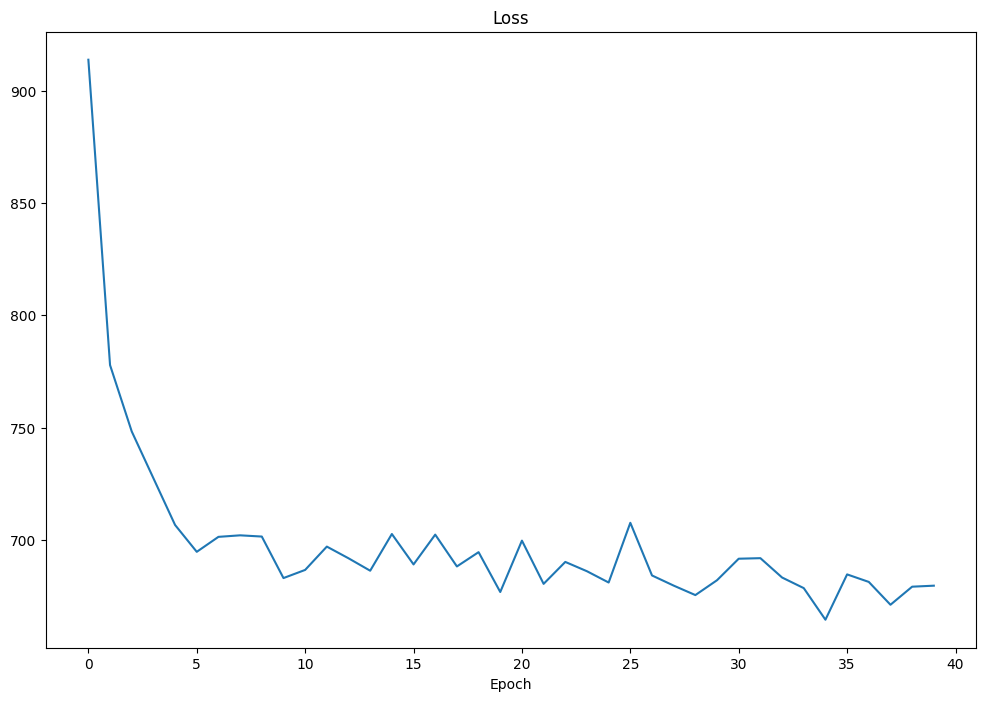

In [ ]:
loss_name = 'bce'
to_reads = False

# create adjacency matrix from graph
user_count, book_count, user_to_idx_map, book_to_idx_map = prep_data(to_reads)

# start wandb run
model_name = init_wandb(loss_name, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs)

# train the model and output results
train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, model_name)

#### 2civ) BPR loss, no to_reads

n_users=1000, n_items=500
n_interactions=30979
n_train=21220, n_test=9759, sparsity=0.06196
Creating interaction matrices R_train and R_test...


/content/drive/MyDrive/EE452_2024_Team5_Project/src/ngcf_utils/load_data.py:131: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -.5).flatten()


Complete. Interaction matrices R_train and R_test created in 0.32341980934143066 sec
Creating adjacency-matrix...
Complete. Adjacency-matrix created in (1500, 1500) 0.07146286964416504 sec.
Transforming adjacency-matrix to NGCF-adjacency matrix...
Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in 0.03860950469970703 sec.
Initializing weights...
Weights initialized.


100%|██████████| 1327/1327 [00:16<00:00, 81.81it/s]


Epoch: 0, Training time: 16.23s, Loss: 681.6321


100%|██████████| 1327/1327 [00:16<00:00, 82.91it/s]


Epoch: 1, Training time: 16.02s, Loss: 651.5705


100%|██████████| 1327/1327 [00:16<00:00, 79.42it/s]


Epoch: 2, Training time: 16.72s, Loss: 635.4447


100%|██████████| 1327/1327 [00:16<00:00, 80.29it/s]


Epoch: 3, Training time: 16.54s, Loss: 654.2938
Counter({1.0: 9759})
128658 6750 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:16<00:00, 82.76it/s]


Epoch: 4, Training time: 16.04s, Loss: 663.7246


100%|██████████| 1327/1327 [00:17<00:00, 76.51it/s]


Epoch: 5, Training time: 17.35s, Loss: 700.2246


100%|██████████| 1327/1327 [00:16<00:00, 82.22it/s]


Epoch: 6, Training time: 16.15s, Loss: 681.9866


100%|██████████| 1327/1327 [00:16<00:00, 82.66it/s]


Epoch: 7, Training time: 16.06s, Loss: 674.7748
Counter({1.0: 9759})
130139 6909 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:16<00:00, 79.54it/s]


Epoch: 8, Training time: 16.69s, Loss: 666.4017


100%|██████████| 1327/1327 [00:16<00:00, 82.60it/s]


Epoch: 9, Training time: 16.07s, Loss: 677.4363


100%|██████████| 1327/1327 [00:16<00:00, 82.55it/s]


Epoch: 10, Training time: 16.08s, Loss: 689.6674


100%|██████████| 1327/1327 [00:15<00:00, 83.40it/s]


Epoch: 11, Training time: 15.92s, Loss: 672.3998
Counter({1.0: 9759})
129748 6841 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:16<00:00, 82.44it/s]


Epoch: 12, Training time: 16.10s, Loss: 679.7668


100%|██████████| 1327/1327 [00:18<00:00, 73.01it/s]


Epoch: 13, Training time: 18.18s, Loss: 688.8834


100%|██████████| 1327/1327 [00:16<00:00, 81.99it/s]


Epoch: 14, Training time: 16.19s, Loss: 686.0479


100%|██████████| 1327/1327 [00:16<00:00, 82.47it/s]


Epoch: 15, Training time: 16.10s, Loss: 674.2750
Counter({1.0: 9759})
126732 6779 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:15<00:00, 83.40it/s]


Epoch: 16, Training time: 15.92s, Loss: 667.3117


100%|██████████| 1327/1327 [00:15<00:00, 83.08it/s]


Epoch: 17, Training time: 15.98s, Loss: 693.1074


100%|██████████| 1327/1327 [00:16<00:00, 81.66it/s]


Epoch: 18, Training time: 16.26s, Loss: 686.4580


100%|██████████| 1327/1327 [00:16<00:00, 78.69it/s]


Epoch: 19, Training time: 16.88s, Loss: 675.3270
Counter({1.0: 9759})
132160 6743 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:16<00:00, 81.99it/s]


Epoch: 20, Training time: 16.19s, Loss: 683.7461


100%|██████████| 1327/1327 [00:17<00:00, 76.88it/s]


Epoch: 21, Training time: 17.27s, Loss: 661.3582


100%|██████████| 1327/1327 [00:15<00:00, 83.17it/s]


Epoch: 22, Training time: 15.97s, Loss: 663.3750


100%|██████████| 1327/1327 [00:15<00:00, 83.13it/s]


Epoch: 23, Training time: 15.97s, Loss: 681.7215
Counter({1.0: 9759})
130981 6736 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:16<00:00, 80.32it/s]


Epoch: 24, Training time: 16.53s, Loss: 658.5814


100%|██████████| 1327/1327 [00:16<00:00, 81.62it/s]


Epoch: 25, Training time: 16.27s, Loss: 673.4314


100%|██████████| 1327/1327 [00:16<00:00, 82.59it/s]


Epoch: 26, Training time: 16.08s, Loss: 659.3846


100%|██████████| 1327/1327 [00:16<00:00, 82.10it/s]


Epoch: 27, Training time: 16.17s, Loss: 649.4727
Counter({1.0: 9759})
129909 6702 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:16<00:00, 78.81it/s]


Epoch: 28, Training time: 16.85s, Loss: 673.2509


100%|██████████| 1327/1327 [00:19<00:00, 69.18it/s]


Epoch: 29, Training time: 19.20s, Loss: 671.9574


100%|██████████| 1327/1327 [00:17<00:00, 75.33it/s]


Epoch: 30, Training time: 17.63s, Loss: 691.1893


100%|██████████| 1327/1327 [00:17<00:00, 76.52it/s]


Epoch: 31, Training time: 17.36s, Loss: 655.7076
Counter({1.0: 9759})
127909 6626 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1327/1327 [00:16<00:00, 80.13it/s]


Epoch: 32, Training time: 16.57s, Loss: 662.2425


100%|██████████| 1327/1327 [00:16<00:00, 79.73it/s]


Epoch: 33, Training time: 16.65s, Loss: 645.2008


100%|██████████| 1327/1327 [00:17<00:00, 77.74it/s]


Epoch: 34, Training time: 17.08s, Loss: 651.1781


100%|██████████| 1327/1327 [00:16<00:00, 78.56it/s]


Epoch: 35, Training time: 16.90s, Loss: 654.2433
Early stopping at step: 5 log:0.23945699632167816
Counter({1.0: 9759})
127786 6724 9759 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


ndcg_20,▁▃▆▆▂▄█▄▅
rec_20,▁▃▆█▃▅▆▅▇
test_f1_score,▅▇▆█▁▂▃▃▅
test_precision,▅▇▆█▁▂▃▃▆
test_recall,▄█▆▅▄▄▃▁▃
training_loss,▆▃▁▃▄█▆▅▄▆▇▅▆▇▆▅▄▇▇▅▆▄▄▆▄▅▄▃▅▅▇▃▄▂▃▃
ndcg_20,0.44693
rec_20,0.23946
test_f1_score,0.09777
test_precision,0.05262
test_recall,0.68901


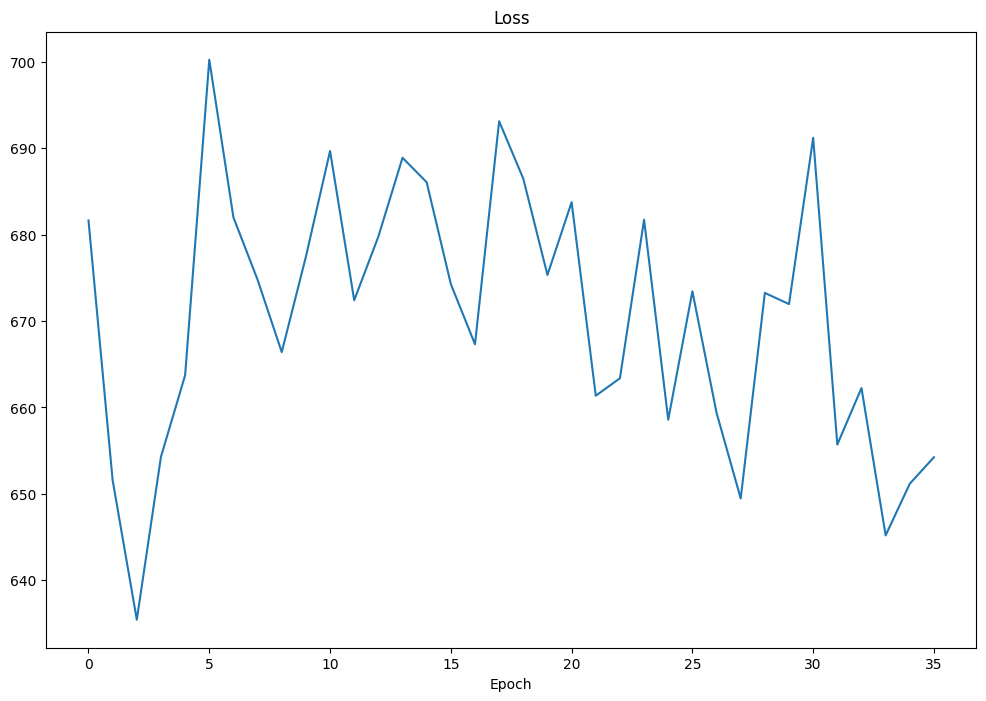

In [ ]:
loss_name = 'bpr'

# start wandb run
model_name = init_wandb(loss_name, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs)

# train the model and output results
train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, model_name)

#### 2cv) BCE loss, to_reads, pos_weight = 20

n_users=1000, n_items=500
n_interactions=33787
n_train=23188, n_test=10599, sparsity=0.06757
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 0.853257417678833 sec
Creating adjacency-matrix...
Complete. Adjacency-matrix created in (1500, 1500) 0.24718832969665527 sec.
Transforming adjacency-matrix to NGCF-adjacency matrix...
Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in 0.09249711036682129 sec.
Initializing weights...


/content/drive/MyDrive/EE452_2024_Team5_Project/src/ngcf_utils/load_data.py:131: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -.5).flatten()


Weights initialized.


100%|██████████| 1450/1450 [00:30<00:00, 46.88it/s]


Epoch: 0, Training time: 30.94s, Loss: 2907.3624


100%|██████████| 1450/1450 [00:19<00:00, 76.25it/s]


Epoch: 1, Training time: 19.03s, Loss: 2657.3015


100%|██████████| 1450/1450 [00:18<00:00, 80.21it/s]


Epoch: 2, Training time: 18.09s, Loss: 2440.0192


100%|██████████| 1450/1450 [00:19<00:00, 75.74it/s]


Epoch: 3, Training time: 19.16s, Loss: 2428.4179
Counter({1.0: 10599})
140215 7722 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:21<00:00, 67.36it/s]


Epoch: 4, Training time: 21.53s, Loss: 2278.1911


100%|██████████| 1450/1450 [00:18<00:00, 76.97it/s]


Epoch: 5, Training time: 18.85s, Loss: 2282.2686


100%|██████████| 1450/1450 [00:22<00:00, 65.11it/s]


Epoch: 6, Training time: 22.28s, Loss: 2187.6518


100%|██████████| 1450/1450 [00:20<00:00, 72.01it/s]


Epoch: 7, Training time: 20.14s, Loss: 2203.8579
Counter({1.0: 10599})
113668 7308 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 81.35it/s]


Epoch: 8, Training time: 17.83s, Loss: 2177.1016


100%|██████████| 1450/1450 [00:18<00:00, 78.68it/s]


Epoch: 9, Training time: 18.45s, Loss: 2194.9755


100%|██████████| 1450/1450 [00:19<00:00, 74.98it/s]


Epoch: 10, Training time: 19.35s, Loss: 2212.9932


100%|██████████| 1450/1450 [00:17<00:00, 81.92it/s]


Epoch: 11, Training time: 17.71s, Loss: 2167.3355
Counter({1.0: 10599})
103009 7107 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:18<00:00, 77.27it/s]


Epoch: 12, Training time: 18.78s, Loss: 2223.9586


100%|██████████| 1450/1450 [00:17<00:00, 82.25it/s]


Epoch: 13, Training time: 17.64s, Loss: 2134.1040


100%|██████████| 1450/1450 [00:17<00:00, 82.60it/s]


Epoch: 14, Training time: 17.57s, Loss: 2160.8619


100%|██████████| 1450/1450 [00:18<00:00, 80.09it/s]


Epoch: 15, Training time: 18.12s, Loss: 2206.8126
Counter({1.0: 10599})
96358 6956 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:18<00:00, 78.90it/s]


Epoch: 16, Training time: 18.39s, Loss: 2152.6825


100%|██████████| 1450/1450 [00:18<00:00, 76.52it/s]


Epoch: 17, Training time: 18.96s, Loss: 2335.5550


100%|██████████| 1450/1450 [00:18<00:00, 79.25it/s]


Epoch: 18, Training time: 18.30s, Loss: 2203.7451


100%|██████████| 1450/1450 [00:18<00:00, 78.98it/s]


Epoch: 19, Training time: 18.37s, Loss: 2178.4391
Counter({1.0: 10599})
95661 6902 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 81.80it/s]


Epoch: 20, Training time: 17.73s, Loss: 2175.3282


100%|██████████| 1450/1450 [00:17<00:00, 81.71it/s]


Epoch: 21, Training time: 17.76s, Loss: 2278.2498


100%|██████████| 1450/1450 [00:18<00:00, 78.12it/s]


Epoch: 22, Training time: 18.57s, Loss: 2171.2363


100%|██████████| 1450/1450 [00:17<00:00, 81.99it/s]


Epoch: 23, Training time: 17.70s, Loss: 2152.9095
Counter({1.0: 10599})
89576 6745 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:18<00:00, 78.39it/s]


Epoch: 24, Training time: 18.51s, Loss: 2154.0177


100%|██████████| 1450/1450 [00:19<00:00, 76.17it/s]


Epoch: 25, Training time: 19.05s, Loss: 2150.6922


100%|██████████| 1450/1450 [00:17<00:00, 82.70it/s]


Epoch: 26, Training time: 17.54s, Loss: 2222.7970


100%|██████████| 1450/1450 [00:17<00:00, 81.61it/s]


Epoch: 27, Training time: 17.79s, Loss: 2224.8468
Counter({1.0: 10599})
90807 6782 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:18<00:00, 78.62it/s]


Epoch: 28, Training time: 18.46s, Loss: 2197.8048


100%|██████████| 1450/1450 [00:17<00:00, 81.54it/s]


Epoch: 29, Training time: 17.79s, Loss: 2138.3702


100%|██████████| 1450/1450 [00:17<00:00, 82.50it/s]


Epoch: 30, Training time: 17.58s, Loss: 2258.8207


100%|██████████| 1450/1450 [00:17<00:00, 81.13it/s]


Epoch: 31, Training time: 17.88s, Loss: 2154.6202
Counter({1.0: 10599})
88432 6726 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:19<00:00, 75.31it/s]


Epoch: 32, Training time: 19.27s, Loss: 2116.1199


100%|██████████| 1450/1450 [00:17<00:00, 82.12it/s]


Epoch: 33, Training time: 17.66s, Loss: 2179.8813


100%|██████████| 1450/1450 [00:17<00:00, 80.67it/s]


Epoch: 34, Training time: 17.98s, Loss: 2239.4952


100%|██████████| 1450/1450 [00:18<00:00, 78.95it/s]


Epoch: 35, Training time: 18.37s, Loss: 2180.2509
Counter({1.0: 10599})
85170 6574 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


100%|██████████| 1450/1450 [00:17<00:00, 82.18it/s]


Epoch: 36, Training time: 17.65s, Loss: 2139.9008


100%|██████████| 1450/1450 [00:17<00:00, 82.84it/s]


Epoch: 37, Training time: 17.52s, Loss: 2152.1440


100%|██████████| 1450/1450 [00:18<00:00, 77.48it/s]


Epoch: 38, Training time: 18.73s, Loss: 2233.5421


100%|██████████| 1450/1450 [00:19<00:00, 75.33it/s]


Epoch: 39, Training time: 19.26s, Loss: 2283.1330
Counter({1.0: 10599})
88296 6736 10599 (1000, 500) torch.Size([1000, 100]) torch.Size([500, 100]) (1000, 500)


ndcg_20,▁▂▆▅▄▅▆▅▆█
rec_20,▁▄▇▇▆▇▇▇██
test_f1_score,▁▄▆▇▇▇▇███
test_precision,▁▄▅▆▆▇▇███
test_recall,█▅▄▃▃▂▂▂▁▂
training_loss,█▆▄▄▂▂▂▂▂▂▂▁▂▁▁▂▁▃▂▂▂▂▁▁▁▁▂▂▂▁▂▁▁▂▂▂▁▁▂▂
ndcg_20,0.44383
rec_20,0.22946
test_f1_score,0.13623
test_precision,0.07629
test_recall,0.63553


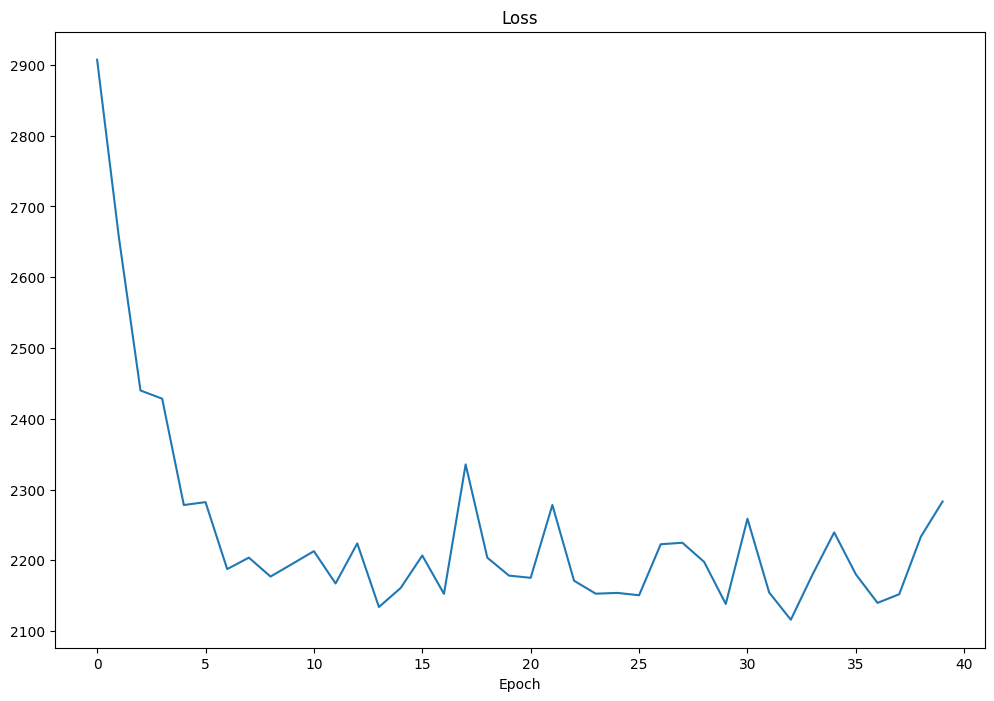

In [ ]:
loss_name = 'bce'
to_reads = True
pos_weight = 20

# create adjacency matrix from graph
user_count, book_count, user_to_idx_map, book_to_idx_map = prep_data(to_reads)

# start wandb run
model_name = init_wandb(loss_name, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs)

# train the model and output results
train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, model_name)

#### 2cvi) BCE loss, to_reads, layers = [64, 32, 32, 32]

n_users=1000, n_items=500
n_interactions=33787
n_train=23188, n_test=10599, sparsity=0.06757
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 0.34628963470458984 sec
Creating adjacency-matrix...
Complete. Adjacency-matrix created in (1500, 1500) 0.07952189445495605 sec.
Transforming adjacency-matrix to NGCF-adjacency matrix...
Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in 0.04631972312927246 sec.
Initializing weights...
Weights initialized.


/content/drive/MyDrive/EE452_2024_Team5_Project/src/ngcf_utils/load_data.py:131: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -.5).flatten()
100%|██████████| 1450/1450 [00:26<00:00, 54.59it/s]


Epoch: 0, Training time: 26.57s, Loss: 1162.6653


100%|██████████| 1450/1450 [00:28<00:00, 51.69it/s]


Epoch: 1, Training time: 28.07s, Loss: 950.3640


100%|██████████| 1450/1450 [00:26<00:00, 55.54it/s]


Epoch: 2, Training time: 26.12s, Loss: 869.0996


100%|██████████| 1450/1450 [00:26<00:00, 55.29it/s]


Epoch: 3, Training time: 26.23s, Loss: 850.5763
Counter({1.0: 10599})
28806 3027 10599 (1000, 500) torch.Size([1000, 212]) torch.Size([500, 212]) (1000, 500)


100%|██████████| 1450/1450 [00:26<00:00, 55.31it/s]


Epoch: 4, Training time: 26.23s, Loss: 838.7014


100%|██████████| 1450/1450 [00:26<00:00, 55.32it/s]


Epoch: 5, Training time: 26.23s, Loss: 844.8554


100%|██████████| 1450/1450 [00:27<00:00, 53.16it/s]


Epoch: 6, Training time: 27.28s, Loss: 821.4761


100%|██████████| 1450/1450 [00:25<00:00, 56.20it/s]


Epoch: 7, Training time: 25.81s, Loss: 830.0133
Counter({1.0: 10599})
29428 3129 10599 (1000, 500) torch.Size([1000, 212]) torch.Size([500, 212]) (1000, 500)


100%|██████████| 1450/1450 [00:25<00:00, 56.57it/s]


Epoch: 8, Training time: 25.64s, Loss: 821.0148


100%|██████████| 1450/1450 [00:25<00:00, 56.20it/s]


Epoch: 9, Training time: 25.82s, Loss: 818.2911


100%|██████████| 1450/1450 [00:26<00:00, 55.70it/s]


Epoch: 10, Training time: 26.05s, Loss: 816.0829


100%|██████████| 1450/1450 [00:27<00:00, 52.16it/s]


Epoch: 11, Training time: 27.81s, Loss: 798.9621
Counter({1.0: 10599})
29324 3413 10599 (1000, 500) torch.Size([1000, 212]) torch.Size([500, 212]) (1000, 500)


100%|██████████| 1450/1450 [00:26<00:00, 55.43it/s]


Epoch: 12, Training time: 26.16s, Loss: 806.6242


100%|██████████| 1450/1450 [00:26<00:00, 55.45it/s]


Epoch: 13, Training time: 26.16s, Loss: 810.6035


100%|██████████| 1450/1450 [00:26<00:00, 55.53it/s]


Epoch: 14, Training time: 26.12s, Loss: 823.7290


100%|██████████| 1450/1450 [00:26<00:00, 55.47it/s]


Epoch: 15, Training time: 26.15s, Loss: 803.2080
Counter({1.0: 10599})
28820 3409 10599 (1000, 500) torch.Size([1000, 212]) torch.Size([500, 212]) (1000, 500)


100%|██████████| 1450/1450 [00:26<00:00, 54.83it/s]


Epoch: 16, Training time: 26.45s, Loss: 806.7466


100%|██████████| 1450/1450 [00:26<00:00, 54.60it/s]


Epoch: 17, Training time: 26.57s, Loss: 804.0835


100%|██████████| 1450/1450 [00:25<00:00, 55.83it/s]


Epoch: 18, Training time: 25.99s, Loss: 792.2792


100%|██████████| 1450/1450 [00:26<00:00, 55.40it/s]


Epoch: 19, Training time: 26.19s, Loss: 808.1368
Counter({1.0: 10599})
27015 3056 10599 (1000, 500) torch.Size([1000, 212]) torch.Size([500, 212]) (1000, 500)


100%|██████████| 1450/1450 [00:26<00:00, 55.18it/s]


Epoch: 20, Training time: 26.29s, Loss: 793.8952


100%|██████████| 1450/1450 [00:26<00:00, 55.36it/s]


Epoch: 21, Training time: 26.20s, Loss: 790.4464


100%|██████████| 1450/1450 [00:27<00:00, 52.29it/s]


Epoch: 22, Training time: 27.74s, Loss: 784.7415


100%|██████████| 1450/1450 [00:26<00:00, 54.79it/s]


Epoch: 23, Training time: 26.47s, Loss: 785.5394
Counter({1.0: 10599})
26343 3157 10599 (1000, 500) torch.Size([1000, 212]) torch.Size([500, 212]) (1000, 500)


100%|██████████| 1450/1450 [00:26<00:00, 55.41it/s]


Epoch: 24, Training time: 26.17s, Loss: 791.5746


100%|██████████| 1450/1450 [00:25<00:00, 55.84it/s]


Epoch: 25, Training time: 25.98s, Loss: 795.3641


100%|██████████| 1450/1450 [00:25<00:00, 56.55it/s]


Epoch: 26, Training time: 25.65s, Loss: 784.1448


100%|██████████| 1450/1450 [00:27<00:00, 53.54it/s]


Epoch: 27, Training time: 27.09s, Loss: 789.4223
Counter({1.0: 10599})
25204 3064 10599 (1000, 500) torch.Size([1000, 212]) torch.Size([500, 212]) (1000, 500)


100%|██████████| 1450/1450 [00:26<00:00, 55.71it/s]


Epoch: 28, Training time: 26.04s, Loss: 803.7919


100%|██████████| 1450/1450 [00:26<00:00, 55.23it/s]


Epoch: 29, Training time: 26.26s, Loss: 786.3826


100%|██████████| 1450/1450 [00:26<00:00, 55.38it/s]


Epoch: 30, Training time: 26.19s, Loss: 789.8422


100%|██████████| 1450/1450 [00:26<00:00, 55.29it/s]


Epoch: 31, Training time: 26.24s, Loss: 786.8656
Counter({1.0: 10599})
26095 3128 10599 (1000, 500) torch.Size([1000, 212]) torch.Size([500, 212]) (1000, 500)


100%|██████████| 1450/1450 [00:27<00:00, 53.21it/s]


Epoch: 32, Training time: 27.26s, Loss: 770.5630


100%|██████████| 1450/1450 [00:26<00:00, 55.48it/s]


Epoch: 33, Training time: 26.15s, Loss: 774.6976


100%|██████████| 1450/1450 [00:26<00:00, 55.12it/s]


Epoch: 34, Training time: 26.32s, Loss: 791.6449


100%|██████████| 1450/1450 [00:26<00:00, 55.15it/s]


Epoch: 35, Training time: 26.30s, Loss: 784.0661
Early stopping at step: 5 log:0.24077674746513367
Counter({1.0: 10599})
25621 3141 10599 (1000, 500) torch.Size([1000, 212]) torch.Size([500, 212]) (1000, 500)


ndcg_20,▁▄▆▇▂▇█▇▇
rec_20,▃▁▆█▂▆█▅▆
test_f1_score,▁▂▇█▄▇▇▇█
test_precision,▁▁▆▆▄▇█▇█
test_recall,▁▃██▂▃▂▃▃
training_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
ndcg_20,0.4705
rec_20,0.24078
test_f1_score,0.17344
test_precision,0.12259
test_recall,0.29635


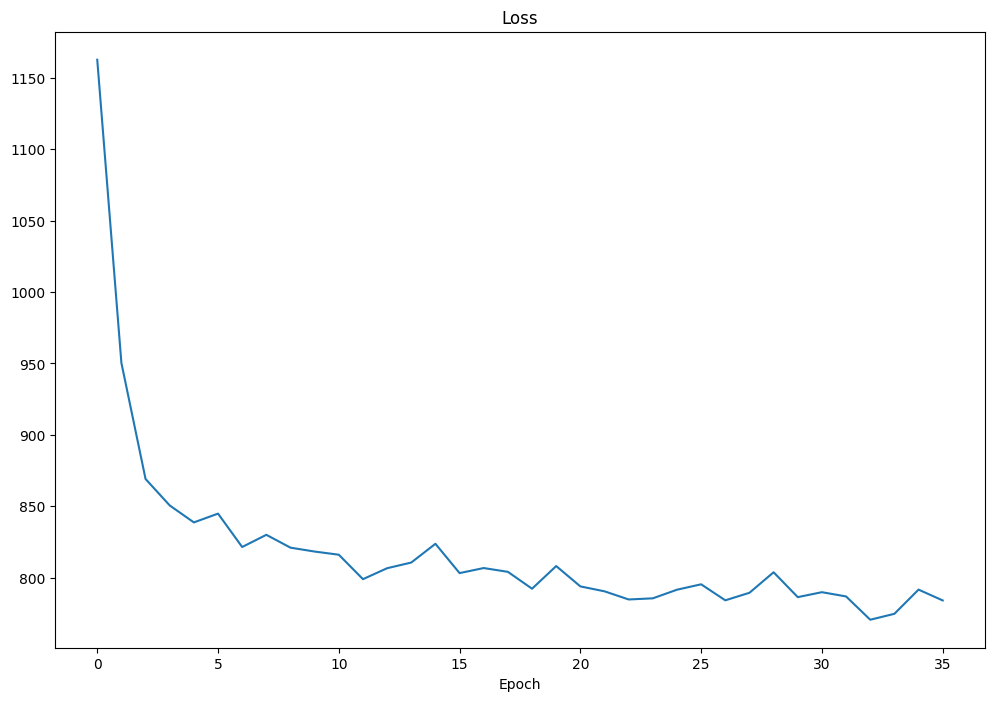

In [ ]:
loss_name = 'bce'
to_reads = True
pos_weight = 1
layers = [64, 32, 32, 32]

# create adjacency matrix from graph
user_count, book_count, user_to_idx_map, book_to_idx_map = prep_data(to_reads)

# start wandb run
model_name = init_wandb(loss_name, to_reads, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs)

# train the model and output results
train_interaction_predictor(loss_name, prob_cutoff, pos_weight, batch_size, layers, emb_dim, lr, reg, mess_dropout, node_dropout, user_count, book_count, k, n_epochs, eval_N, save_results, model_name)

# 2.5 Positive Interaction Prediction (SVD)

In [27]:
import networkx as nx
import numpy as np
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k

In [18]:
to_reads = True
if to_reads == True:
    train_graph = nx.read_graphml("data/bipartite_sample_train_wtr.graphml")
    test_graph = nx.read_graphml("data/bipartite_sample_test_wtr.graphml")
else:
    train_graph = nx.read_graphml("data/bipartite_sample_train.graphml")
    test_graph = nx.read_graphml("data/bipartite_sample_test.graphml")

user_nodes = [node for node, data in train_graph.nodes(data=True) if data.get('node_type') == 'user']
book_nodes = [node for node, data in train_graph.nodes(data=True) if data.get('node_type') == 'book']

dataset = Dataset()
dataset.fit(user_nodes, items=book_nodes)
(interactions, weights) = dataset.build_interactions((edge[0], edge[1]) for edge in train_graph.edges())

model = LightFM(loss='logistic')
model.fit(interactions, epochs=5)

In [43]:
def ndcg_at_k(model, test_interactions, k=20):
    ndcg_values = []
    for user_id, row in enumerate(test_interactions.toarray()):
        if not np.any(row):
            continue
        
        scores = model.predict(user_id, np.arange(len(row)))
        top_indices = np.argsort(-scores)[:k]
        true_interactions = np.where(row)[0]

        dcg = 0
        for rank, index in enumerate(top_indices, 1):
            if index in true_interactions:
                dcg += 1 / np.log2(rank + 1)

        idcg = sum(1 / np.log2(rank + 1) for rank in range(1, min(k, len(true_interactions)) + 1))
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_values.append(ndcg)

    return np.mean(ndcg_values)

In [44]:
print(precision_at_k(model, interactions, k=20).mean(), recall_at_k(model, interactions, k=20).mean(), ndcg_at_k(model, interactions))

test_interactions, _ = dataset.build_interactions((edge[0], edge[1]) for edge in test_graph.edges())
print(precision_at_k(model, test_interactions, k=20).mean(), recall_at_k(model, test_interactions, k=20).mean(), ndcg_at_k(model, test_interactions))

0.25978333 0.09934581935634833 0.2736972876628051
0.105349995 0.09203873030731219 0.1163437143226705
